Authors: Jinanshi Mehta & Kelly Huang

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set your dataset path and parameters
data_path = "/content/drive/MyDrive/Final Train"
batch_size = 32
target_size = (224, 224)

In [ ]:
from PIL import Image
import os

def validate_images(image_directory):
    for filename in os.listdir(image_directory):
        file_path = os.path.join(image_directory, filename)
        try:
            with Image.open(file_path) as img:
                img.verify()  # Verify that it is, in fact, an image
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)  # Print out the names of corrupt files

# Call the function
validate_images('/content/drive/MyDrive/Final Train/Yohji Yamamoto')

In [ ]:
Image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Data generators
train_generator = Image_datagen.flow_from_directory(
    data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = Image_datagen.flow_from_directory(
    data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1756 images belonging to 7 classes.
Found 435 images belonging to 7 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

['Alexander McQueen',
 'Burberry',
 'Chanel',
 'Giorgio Armani',
 'Stella McCartney',
 'Versace',
 'Yohji Yamamoto']

In [ ]:
train_generator.class_indices

{'Alexander McQueen': 0,
 'Burberry': 1,
 'Chanel': 2,
 'Giorgio Armani': 3,
 'Stella McCartney': 4,
 'Versace': 5,
 'Yohji Yamamoto': 6}

In [ ]:
# Calculate the correct steps per epoch
train_samples = train_generator.samples  # Total number of training samples
validation_samples = validation_generator.samples  # Total number of validation samples
batch_size = 32  # Assuming your batch size is 32

steps_per_epoch = train_samples // batch_size
validation_steps = validation_samples // batch_size
print(f"Total training samples: {train_samples}")
print(f"Total validation samples: {validation_samples}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Total training samples: 1756
Total validation samples: 435
Steps per epoch: 54
Validation steps: 13


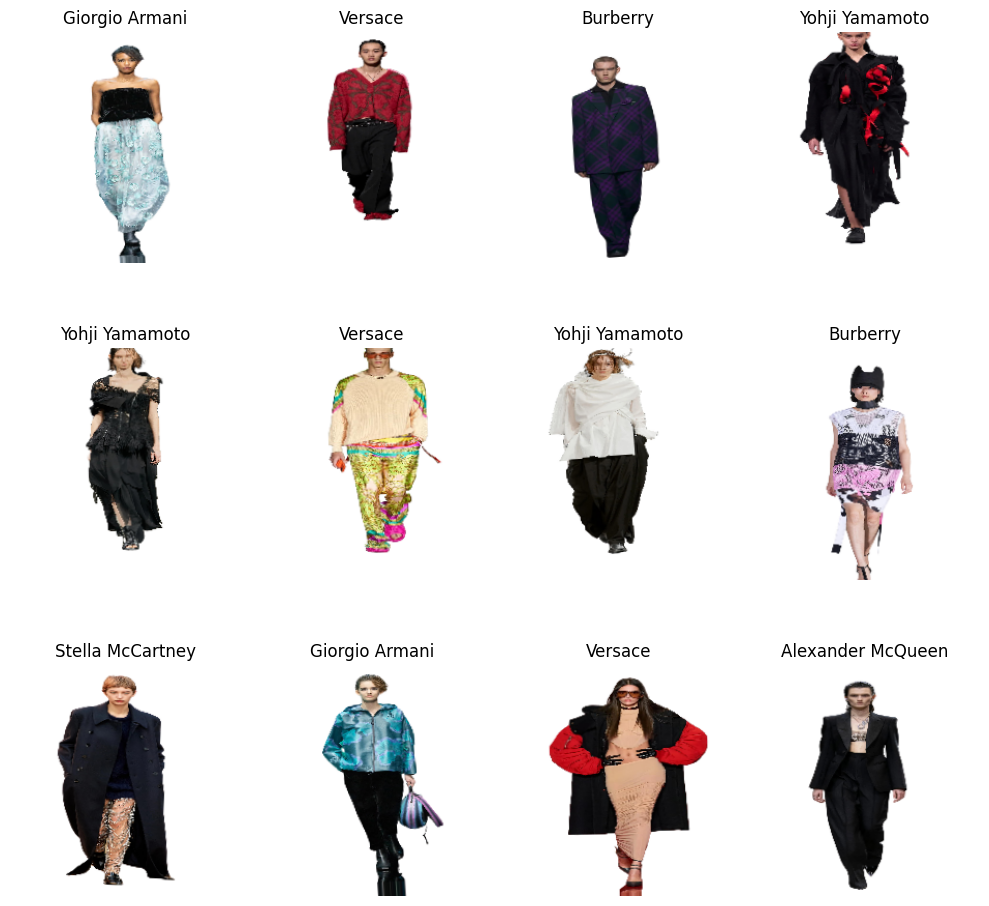

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_generator:
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        # If images are normalized (i.e., rescale=1./255), you need to reverse this before displaying
        img_to_display = image_batch[i].astype('uint8') if np.max(image_batch[i]) > 1 else (image_batch[i] * 255).astype('uint8')
        plt.imshow(img_to_display)
        class_index = np.argmax(labels_batch[i])
        plt.title(class_names[class_index])
        plt.axis("off")
    break  # Only display a single batch

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

# Load VGG16 with pre-trained ImageNet weights, exclude the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = models.Sequential([
    base_model,  # This is the VGG16 base
    layers.Flatten(),

    # Dropout layer here to reduce overfitting
    layers.Dropout(0.5),

    # Dense layers
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model (50 epochs)
history = model.fit(
    train_generator,
    steps_per_epoch=54,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=13
)

Epoch 1/50
54/54 [==============================] - 2331s 43s/step - loss: 2.0416 - accuracy: 0.3376 - val_loss: 1.2654 - val_accuracy: 0.5457
Epoch 2/50
54/54 [==============================] - 383s 7s/step - loss: 1.2370 - accuracy: 0.5603 - val_loss: 1.2992 - val_accuracy: 0.5024
Epoch 3/50
54/54 [==============================] - 375s 7s/step - loss: 1.0968 - accuracy: 0.6079 - val_loss: 1.1076 - val_accuracy: 0.5841
Epoch 4/50
54/54 [==============================] - 371s 7s/step - loss: 0.9369 - accuracy: 0.6549 - val_loss: 1.0695 - val_accuracy: 0.6178
Epoch 5/50
54/54 [==============================] - 368s 7s/step - loss: 0.9120 - accuracy: 0.6671 - val_loss: 1.0739 - val_accuracy: 0.6154
Epoch 6/50
54/54 [==============================] - 374s 7s/step - loss: 0.8788 - accuracy: 0.6852 - val_loss: 0.9502 - val_accuracy: 0.6659
Epoch 7/50
54/54 [==============================] - 362s 7s/step - loss: 0.7402 - accuracy: 0.7303 - val_loss: 0.8357 - val_accuracy: 0.7043
Epoch 8/50


In [ ]:
model.save('fashion_final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 7)                 903       
                                                                 
Total params: 21171271 (80.76 MB)
Trainable params: 6456

In [ ]:
history

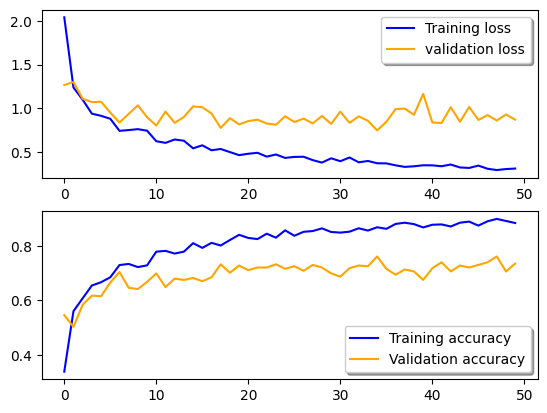

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='orange', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='orange',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

14/14 [==============================] - 81s 6s/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Precision: 0.12645943169780155
Recall: 0.129251774894619
F1 Score: 0.1254617783170256
Confusion Matrix:
[[ 1  9 11 11  3  4  4]
 [ 4 14 11 16  2  9  8]
 [ 4 21 11 21  5  6  9]
 [ 6 12 16 15  4 19 11]
 [ 3 10  5 14  4  4  5]
 [ 3 18 14 20 11  9  4]
 [ 3  9  8  7  4  7  6]]
